# Attribution Model Results & Evaluation
## Import Dependencies and Load Data

In [55]:
import itertools
from collections import Counter, defaultdict
from itertools import permutations, combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from gekko import GEKKO
from pandas.plotting import scatter_matrix
from pandas_profiling import ProfileReport
from PIL import Image

%matplotlib inline
pd.options.mode.chained_assignment = None
sns.set_palette('rocket_r')

In [56]:
df = pd.read_csv('data/attribution_data.csv')
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [57]:
U_shaped = pd.read_csv('results/U_shaped.csv').set_index('Unnamed: 0').sort_index()
first_touch = pd.read_csv('results/first_touch.csv').set_index('Unnamed: 0').sort_index()
last_non_direct = pd.read_csv('results/last_non_direct.csv').set_index('Unnamed: 0').sort_index()
last_touch = pd.read_csv('results/last_touch.csv').set_index('Unnamed: 0').sort_index()
linear = pd.read_csv('results/linear.csv').set_index('Unnamed: 0').sort_index()
markov = pd.read_csv('results/markov.csv').set_index('Unnamed: 0').sort_index()
pos_decay = pd.read_csv('results/pos_decay.csv').set_index('Unnamed: 0').sort_index()
shapley = pd.read_csv('results/shapley.csv').set_index('Unnamed: 0').sort_index()

## Results Table

In [58]:
combined = pd.concat([
    first_touch, last_touch, last_non_direct,
    linear, U_shaped, pos_decay, markov, shapley
], 1)
combined.columns = [
    'First Touch', 'Last Touch', 'Last Non-Direct Touch', 'Linear', 
    'U-Shaped', 'Position Decay', 'Markov', 'Shapley'
]

combined['Mean'] = round(combined.mean(axis=1), 2)
combined

,First Touch,Last Touch,Last Non-Direct Touch,Linear,U-Shaped,Position Decay,Markov,Shapley,Mean
Unnamed: 0,,,,,,,,,
Facebook,32.59,30.05,29.97,16.28,16.28,17.10,28.55,27.29,24.76
Instagram,14.78,12.72,13.22,16.56,16.65,17.14,15.76,13.11,14.99
Online Display,8.95,12.13,11.37,26.43,26.61,25.44,12.85,14.26,17.26
Online Video,25.20,19.32,20.47,13.11,12.99,14.68,15.38,14.27,16.93
Paid Search,18.47,25.78,24.97,27.63,27.48,25.64,27.46,31.06,26.06


Facebook and Paid Search seem to dominate in most with most of the models. Online Display has been almost entirely consistent in getting the lowest conversion credit. We'll take the mean across all models to get rid of biases. Even though our results are similar across the board, we should aggregate our results because we might want to invest \$1 million dollars into one marketing channel. For now, well use our means as the final weighting. We could experience with different weightings and aggregations by means of A/B-testing over several months.

Some other aggregate measures we can try are the median or quantile-based measures.

## Visualization

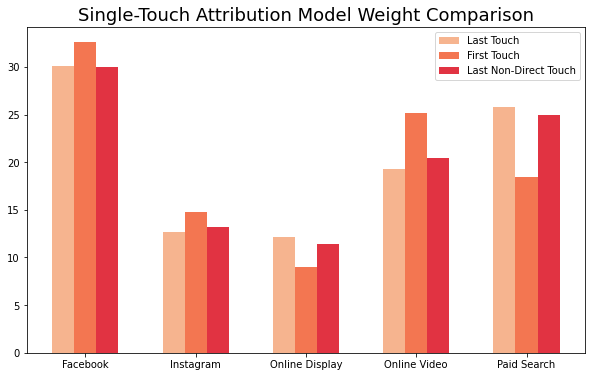

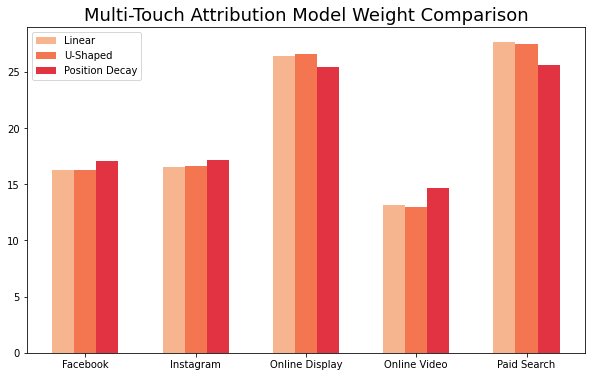

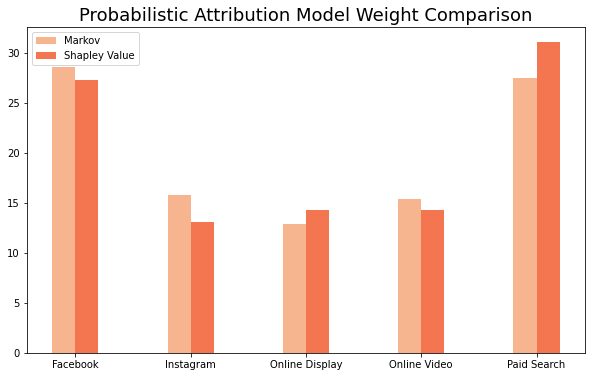

In [59]:
plt.subplots(figsize=(10, 6))
x = np.arange(len(first_touch.index))
plt.bar(x - 0.2, last_touch['Weight (%)'], 0.2, label='Last Touch')
plt.bar(x, first_touch['Weight (%)'], 0.2, label='First Touch')
plt.bar(x + 0.2, last_non_direct['Weight (%)'], 0.2, label='Last Non-Direct Touch')
plt.xticks(x, first_touch.index)
plt.title('Single-Touch Attribution Model Weight Comparison', fontsize=18)
plt.legend()
plt.show()

plt.subplots(figsize=(10, 6))
plt.bar(x - 0.2, linear['Weight (%)'], 0.2, label='Linear')
plt.bar(x, U_shaped['Weight (%)'], 0.2, label='U-Shaped')
plt.bar(x + 0.2, pos_decay['Weight (%)'], 0.2, label='Position Decay')
plt.xticks(x, first_touch.index)
plt.title('Multi-Touch Attribution Model Weight Comparison', fontsize=18)
plt.legend()
plt.show()

plt.subplots(figsize=(10, 6))
plt.bar(x - 0.1, markov['Weight (%)'], 0.2, label='Markov')
plt.bar(x + 0.1, shapley['Weight (%)'], 0.2, label='Shapley Value')
plt.xticks(x, first_touch.index)
plt.title('Probabilistic Attribution Model Weight Comparison', fontsize=18)
plt.legend()
plt.show()

It's important to note that we shouldn't *just* invest in Paid Search and Fac